Irena Vent

## Natural Language Processing

*   **data**: Amazon Reviews
*   **dataset**: Musical Instruments
*   **obetivo**: obtener un modelo de clasificación binaria que clasifique si una reseña es positiva o negativa

# 1. Análisis exploratorio de los datos

**NOTA** En este ejercicio la división train-test se realizará después de la exploración y preprocesamiento

## Preparación del entorno

In [517]:
#! wget https://transfer.sh/JGREuX/requirements.txt

In [518]:
#! pip install -r requirements.txt

In [519]:
from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

## Carga de datos

In [520]:
# descargamos dataset
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz

--2022-07-03 12:04:49--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2460495 (2.3M) [application/x-gzip]
Saving to: ‘reviews_Musical_Instruments_5.json.gz.1’

reviews_Musical_Ins 100%[===================>]   2.35M  1.33MB/s    in 1.8s    

2022-07-03 12:04:51 (1.33 MB/s) - ‘reviews_Musical_Instruments_5.json.gz.1’ saved [2460495/2460495]



In [521]:
# montamos drive
# from google.colab import drive
# drive.mount('/content/drive')

In [522]:
# descomprimimos y cargamos Corpus desde colab
data = pd.read_json('/content/reviews_Musical_Instruments_5.json.gz', lines=True, compression='gzip')

# cargamos Corpus desde drive
#data = pd.read_json('/content/drive/MyDrive/reviews_Musical_Instruments_5.json', lines = True)

# mostramos data
print('Tamaño del dataset -->', data.shape)
pd.set_option('display.max_columns', None)
data.head(5)

Tamaño del dataset --> (10261, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


## Eliminamos columnas irrelevantes 

In [523]:
# comprobamos datos
data.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Nos quedamos con las columnas:


*   reviewText
*   overall



In [524]:
# eliminamos columnas irrelevantes
data = data.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis = 1)
print('Tamaño del dataset tras elminar columnas -->', data.shape)

Tamaño del dataset tras elminar columnas --> (10261, 2)


## Distribución de reviews según número de estrellas

In [525]:
# comprobamos el rango de sore
set(data['overall'])

{1, 2, 3, 4, 5}

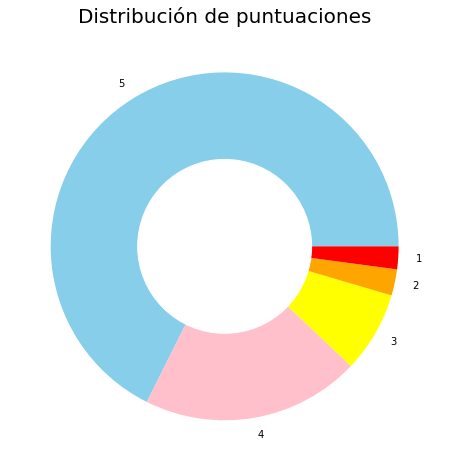

In [526]:
# preparamos los datos
score = data['overall'].value_counts()
numbers = score.index
quantity = score.values

# visualizamos las distribuciones
custom_colors = ['skyblue', 'pink', 'yellow', 'orange', 'red']

plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title('Distribución de puntuaciones', fontsize=20)

plt.show()

## Convertimos variable objetivo (reviews) en variable binaria

In [527]:
# nota de conversión:
# overall < 3 = 0 --> negativa
# overall > 3 = 1 --> positiva

# conversión
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 0
    else:
        return 1

data['sentiment_label'] = data.apply(lambda row: label_sentiment(row), axis=1)

In [528]:
data.head(5)

,reviewText,overall,sentiment_label
0,"Not much to write about here, but it does exac...",5,1
1,The product does exactly as it should and is q...,5,1
2,The primary job of this device is to block the...,5,1
3,Nice windscreen protects my MXL mic and preven...,5,1
4,This pop filter is great. It looks and perform...,5,1


## Distribución del dataset según tipo de reseña

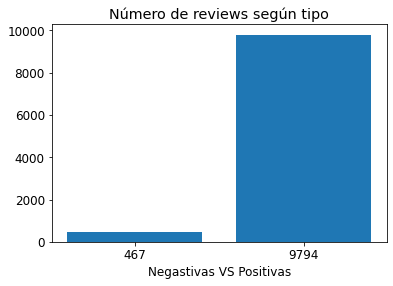

In [529]:
# preparamos los datos
score = data['sentiment_label'].value_counts()
numbers = score.index
quantity = score.values

# visualizamos las distribuciones
plt.bar(numbers, quantity, align='center')
plt.xticks(numbers, quantity)
plt.xlabel('Negastivas VS Positivas')
plt.title('Número de reviews según tipo')

plt.show()

Observamos que el dataset está muy **desbalanceado**. 

Una opción para reducir el desbalanceo es aplicar **data augmentation**, algunos métodos a aplicar, teniendo en cuenta el probelma a resolver son:

* Back translation
* Synonym Replacement
* Shuffle Sentences Transform

Anotar que al tener un dataset tan desbalanceado es probale que la elección de uno u otro método debe ser estudiada en profundidad. Además tener en cuenta que los datos generados no deben participar en la procesos de validación de los modelos. 

**NOTA IMPORTANTE** 

Para desarrollar el ejercicio cogeremos únicamente 500 muestras positivas 

## Creamos SUBSET

In [530]:
# creamos subset
data_subset = data.drop(data.query('sentiment_label == 1').sample(frac=0.95,random_state=1).index)

# hacemos reset del index del dataset
data_subset.reset_index(drop=True, inplace=True)

# mostamos datos
print('Tamaño del data_subset -->', data_subset.shape)
data_subset.head(5)

Tamaño del data_subset --> (957, 3)


,reviewText,overall,sentiment_label
0,I bought this to use with my keyboard. I wasn'...,2,0
1,This Fender cable is the perfect length for me...,4,1
2,The Fender 18 Feet California Clear Instrument...,5,1
3,Realtively inexpensive patch cable for electri...,5,1
4,I didn't expect this cable to be so thin. It's...,2,0


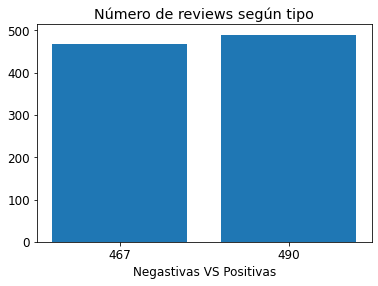

In [531]:
# preparamos los datos
score = data_subset['sentiment_label'].value_counts()
numbers = score.index
quantity = score.values

# visualizamos las distribuciones
plt.bar(numbers, quantity, align='center')
plt.xticks(numbers, quantity)
plt.xlabel('Negastivas VS Positivas')
plt.title('Número de reviews según tipo')

plt.show()

## Número de frases y palabras en el dataet



Número de frases en todo el corpus

In [532]:
sentences = list()

for review in data[['reviewText']].values:
  for sentnce in review[0].split('.'):
    sentences.append(sentnce)

print(f'Total de frases: {len(sentences)}') 

Total de frases: 74438


Número de palabras en todo el dataset

In [533]:
tokens = list()

for review in data[['reviewText']].values:
  for token in review[0].split():
    tokens.append(token)

print(f'Total de palabras: {len(tokens)}') 

Total de palabras: 925371


## Procesado de los datos para la fase de visulización y exploración

In [534]:
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords 

# lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# stemming 
from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [535]:
def review_to_words(review):

  # eliminamos las etiquetas HTML
  text = BeautifulSoup(review, "html5lib").get_text()

  # convertimos a minúscula y quitamos todo lo que no sea texto o números
  text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

  # tokenizamos - dividimos por espacios
  words = text.split()

  # eliminamos stopwords
  words = [w for w in words if w not in stopwords.words("english")]

  # aplicamos stemming
  #words = [PorterStemmer().stem(w) for w in words]
  
  # prueba Lemmatizer
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(w).strip() for w in words]
    
  return words


**NOTA** Haremos uso de la lista completa de stop words únicamente para la exploración y visulización de los datos. Para el preprocesado de los datos es fundamental analizar si debemos o no eliminar ciertas stop words.

Al estar ante un análisis de sentimiento (valoraciones positiva o negativa) la eliminación de ciertas stop words pueden sesgar e incluso cambiar el significado de los datos reales.



## Frecuencia y visualizaciones

In [536]:
from collections import Counter
import matplotlib.pyplot as plt

Separamos y preparamos los datos según tipo de reseñas:

*   todas
*   positivas
*   negativas


In [537]:
# reseñas all
words_data = list(map(review_to_words, data_subset["reviewText"]))
join_words_data = [word for innerList in words_data for word in innerList]

# reseñas negativas
neg_reviews = list(map(review_to_words, data_subset[data_subset['sentiment_label'] == 0]['reviewText']))
join_neg_reviews = [word for innerList in neg_reviews for word in innerList]

# reseñas postivas
pos_reviews = list(map(review_to_words, data_subset[data_subset['sentiment_label'] == 1]['reviewText']))
join_pos_reviews = [word for innerList in pos_reviews for word in innerList]

In [538]:
print(f'Número de palabras totales: {len(join_words_data)}') 
print(f'Número de palabras reseñas negativas: {len(join_neg_reviews)}') 
print(f'Número de palabras reseñas positivas: {len(join_pos_reviews)}') 

Número de palabras totales: 47196
Número de palabras reseñas negativas: 25226
Número de palabras reseñas positivas: 21970


## Palabras más frecuentes en todo el dataset

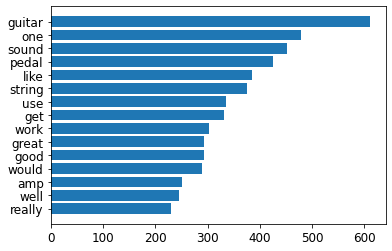

In [539]:
wf = Counter(join_words_data)

wf_most_common = wf.most_common(15)
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

## N-grams

Por las carcaterísticas y tamaño de las reviews consideramos hacer une stiudio con de bi tri-gramas. 

In [540]:
from nltk import ngrams
from nltk.probability import FreqDist

In [541]:
# preparación de los datos

def n_grams_freq(data_subset, num):
  ngrams_words = list(ngrams(data_subset, num))
  ngrams_freq = FreqDist(ngrams_words)
  return ngrams_freq

In [542]:
# visulización 

def plot_n_grams_freq(data_subset, num):

  ngrams_freq = n_grams_freq(data_subset, num)

  ng_freq_most_common = ngrams_freq.most_common(15)
  ngs_ = [str(ng[0]) for ng in ng_freq_most_common]
  ngs_f_ = [ng[1] for ng in ng_freq_most_common]
  ngs_f_, ngs_ = zip(*sorted(zip(ngs_f_, ngs_)))

  plt.barh(ngs_, ngs_f_)
  plt.title('Bigram frequencies')
  plt.show()

### **bi-grams**

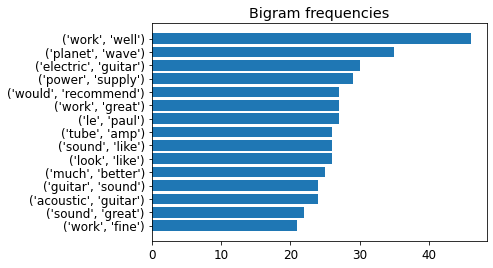

In [543]:
# todo el dataset
plot_n_grams_freq(join_words_data, 2)

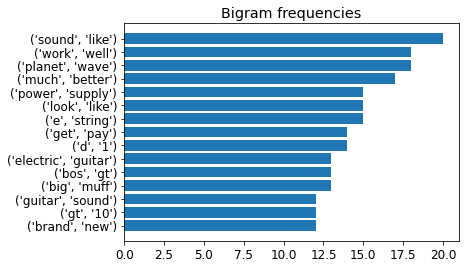

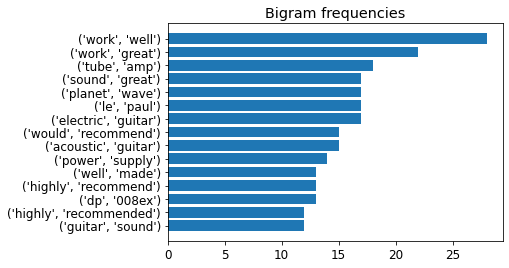

In [544]:
# reseñas negativas
plot_n_grams_freq(join_neg_reviews, 2)
# reseñas postivias
plot_n_grams_freq(join_pos_reviews, 2)

### **tri-grams**

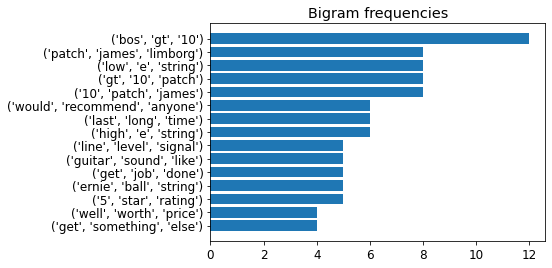

In [545]:
# todo el dataset
plot_n_grams_freq(join_words_data, 3)

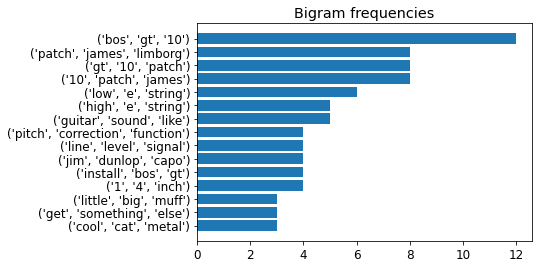

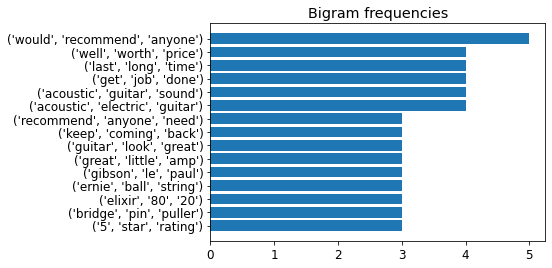

In [546]:
# reseñas negativas
plot_n_grams_freq(join_neg_reviews, 3)
# reseñas postivias
plot_n_grams_freq(join_pos_reviews, 3)

## Nube de palabras

In [547]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [548]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          background_color="white",
                          stopwords = STOPWORDS.update(['guitar','sound','pedal','string','one','amp'])).generate(' '.join(text))
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

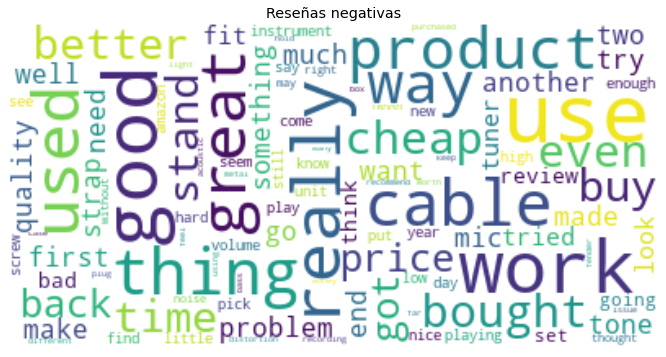

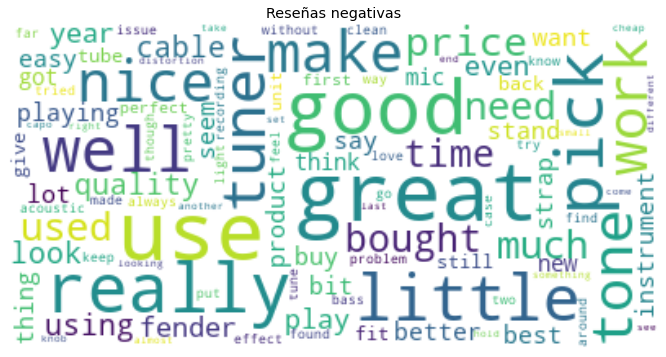

In [549]:
# reseñas nedativas
rn = 'Reseñas negativas'
plot_word_cloud(join_neg_reviews, rn)

# reseñas postivias
rp = 'Reseñas negativas'
plot_word_cloud(join_pos_reviews, rp)

### **Observaciones**
* Es necesario relizar limpieza de números y letras;
* El estudio con 2 y 3 n-grams no resulta satisfactorio, dado que aun eliminando las palabras más repetidas en todo el dataset sigue sin verse una clara diferenciacieon entre las palabras de reseñas posivitas y negativas;
* Aun así parece que el estudio de **n-grams** muestra que la moyoría de las reseñas inciden para su valoración en caracterísitcas en el funcionamiento y el sonido.
* En la nube de palabras llama la atención que en reseñas negativas destaca la palabra 'cheap' y en positivas 'price', cláreamente ambas palabras ubicadas en sus ámbitos muestras que el valor del producto es tenido en cuenta para la valoración;

Vamos a relizar relizar el estudio de 4-ngrams y visulización de nube de palabras sin eliminar sotp_words para comprobar si podemos ver mejor una diferenciación entre reseñas negativas y positivas;

## 4-grams y nube de palabras **sin excluir stop words**

In [550]:
def review_withSW(review):

  # eliminamos las etiquetas HTML
  text = BeautifulSoup(review, "html5lib").get_text()

  # convertimos a minúscula y quitamos todo lo que no sea texto o números
  text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

  # tokenizamos - dividimos por espacios
  words = text.split()

  # eliminamos stopwords
  #words = [w for w in words if w not in stopwords.words("english")]

  # aplicamos stemming
  #words = [PorterStemmer().stem(w) for w in words]
  
  # prueba Lemmatizer
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(w).strip() for w in words]
    
  return words

In [551]:
# reseñas all
words_data_sw = list(map(review_withSW, data_subset["reviewText"]))
words_data_sw = [word for innerList in words_data_sw for word in innerList]

# reseñas negativas
neg_reviews_sw = list(map(review_withSW, data_subset[data_subset['sentiment_label'] == 0]['reviewText']))
neg_reviews_sw = [word for innerList in neg_reviews_sw for word in innerList]

# reseñas postivas
pos_reviews_sw = list(map(review_withSW, data_subset[data_subset['sentiment_label'] == 1]['reviewText']))
pos_reviews_sw = [word for innerList in pos_reviews_sw for word in innerList]

**4-ngrams**

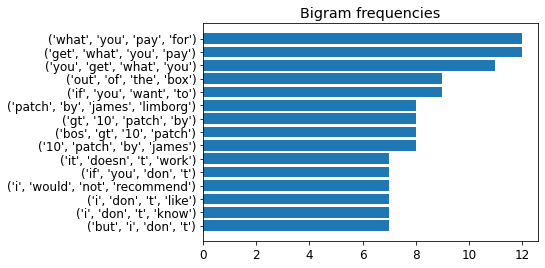

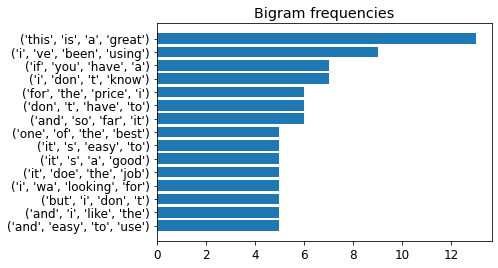

In [552]:
# reseñas negativas
plot_n_grams_freq(neg_reviews_sw, 4)
# reseñas postivias
plot_n_grams_freq(pos_reviews_sw, 4)

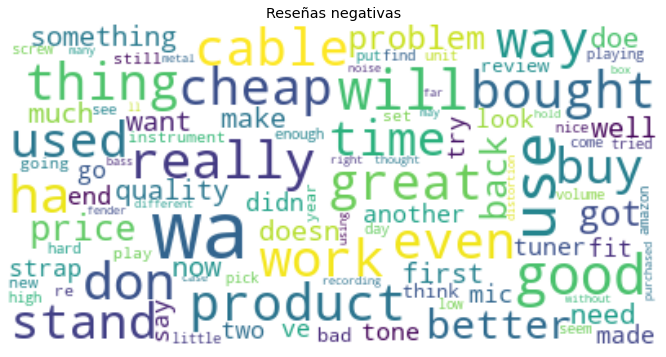

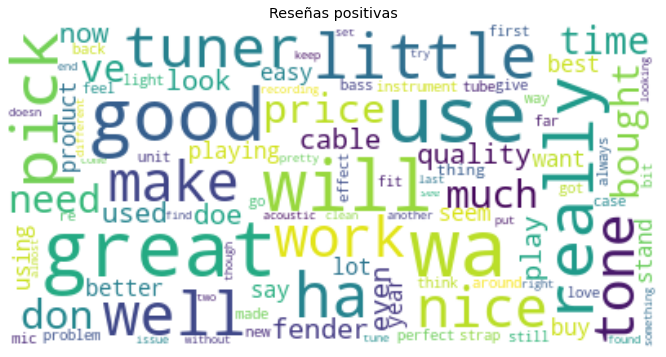

In [553]:
# reseñas nedativas
rn = 'Reseñas negativas'
plot_word_cloud(neg_reviews_sw, rn)

# reseñas postivias
rp = 'Reseñas positivas'
plot_word_cloud(pos_reviews_sw, rp)

Parece que con los stop words sí ha habido una mejor intepretabilidad de negativas sobre positivas, sobre todo en la parte de n-grams, donde podemos observar frase como "i'dont like", "it doesn't work", etc. 

## Word Embedding

Realizamos el estudio de similitud con Word2Vec, usando tanto la arquitectura CBOW como Skip-gram, aunque debemos tener en cuenta que para un número reducido de datos, como es nuestro caso, Skip-gram suele tener un mejor comportamiento.

In [554]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

### CBOW y Skip-gram palabras similares

**Hiperparámetros**

In [555]:
# hiperparámetros

sg_params = {
    'size': 200,
    'window': 10,
    'min_count': 5,
    'sg': 1,
    'hs': 1,
    'negative': 20,
    'seed': 20
}

cbow_params = {
    'size': 200,
    'window': 10,
    'min_count': 5,
    'sg': 0,
    'hs': 1,
    'negative': 20,
    'seed': 20
}

**Inicializamos objetos Woed2Vec**

In [556]:
# Skip Gram
w2v_sg = Word2Vec(**sg_params)

# CBOW
w2v_cbow = Word2Vec(**cbow_params)

**Vocabulario**

In [557]:
# Skip Gram
w2v_sg.build_vocab(words_data)

# CBOW
w2v_cbow.build_vocab(words_data)

**Entrenamos**

In [558]:
# Skip Gram
w2v_sg.train(sentences=words_data, total_examples=w2v_sg.corpus_count, epochs=10)

(354812, 471960)

In [559]:
# CBOW
w2v_cbow.train(sentences=words_data, total_examples=w2v_cbow.corpus_count, epochs=10)

(354972, 471960)

In [560]:
len(words_data[1])

33

In [561]:
words_data[1]

['fender',
 'cable',
 'perfect',
 'length',
 'sometimes',
 'find',
 'bit',
 'long',
 'mind',
 'build',
 'quality',
 'great',
 'know',
 'last',
 'gripe',
 'cable',
 'metal',
 'sleeve',
 'get',
 'unscrewed',
 'way',
 'easily',
 'requiring',
 'tighten',
 'often',
 'sound',
 'quality',
 'affected',
 'color',
 'cool',
 'definitely',
 'try',
 'cable']

**Guardamos los modelos**

In [562]:
w2v_sg.save('./w2v_sg_d300_mc5_w10.pkl')
w2v_cbow.save('./w2v_cbow_d300_mc5_w10.pkl')

**Mostrar palabras más similares**

In [563]:
def print_sim_words(word, model1, model2):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for (sim1, sim2) in zip(model1.wv.most_similar(word), model2.wv.most_similar(word)):
        print("{}:{}{:.3f}{}{}:{}{:.3f}".format(sim1[0],
                                               " "*(20-len(sim1[0])), 
                                               sim1[1], 
                                               " "*10, 
                                               sim2[0],
                                               " "*(20-len(sim2[0])),
                                               sim2[1]))
    print("\n")

In [564]:
words = ('guitar', 'cable', 'string', 'keyboard')
[print_sim_words(word, w2v_cbow, w2v_sg) for word in words]

Most similar to guitar
----------------------
acoustic:            0.952          drawer:              0.679
tuning:              0.940          dust:                0.671
tune:                0.937          acoustic:            0.666
electric:            0.888          banjo:               0.665
capo:                0.874          son:                 0.663
hole:                0.874          trust:               0.662
put:                 0.856          gibson:              0.661
bass:                0.854          feeling:             0.660
keep:                0.853          cheer:               0.658
used:                0.844          wipe:                0.657


Most similar to cable
---------------------
jack:                0.888          connector:           0.671
1:                   0.879          lifetime:            0.645
star:                0.874          ft:                  0.641
4:                   0.853          hosa:                0.629
5:                   0.835

[None, None, None, None]

Aunque CBOW parece arrojar mejores resultados crremos que las palabras más similares están contenidas en el Skip-gram.

### Visualización 2D

In [565]:
import numpy as np
from sklearn.manifold import TSNE

**Skip Gram**

In [566]:
# palabras para crear tópicos
keys = ['guitar', 'great', 'string', 'microphone']

embedding_clusters = []
# creamos lista de clusters
word_clusters = []

#iteramos en cada palabra y buscamos las palabras mas similiraes para cada palababra, las 10 mas similares.
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

# reducimos dimensionalidad a 2D para poder representar

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


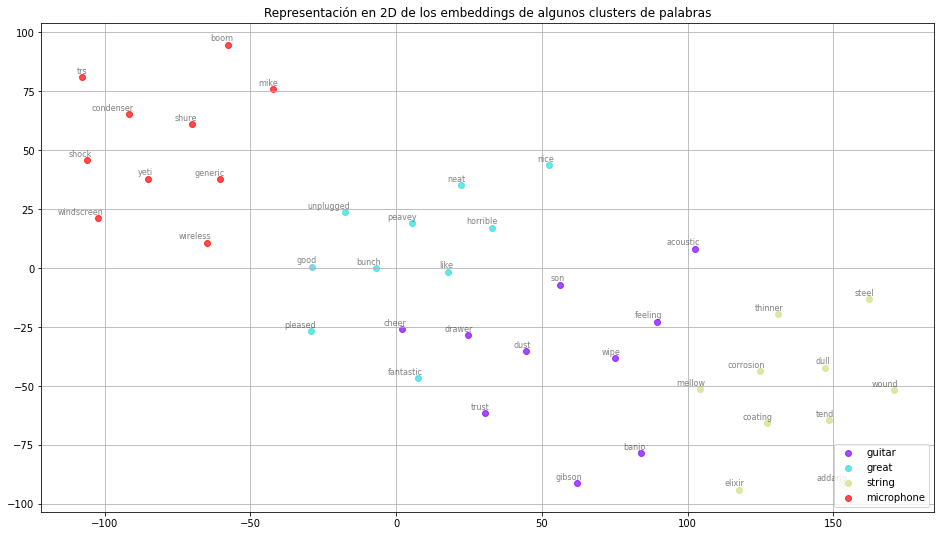

In [567]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

**CBOW**

In [568]:
# palabras para crear tópicos
keys = ['guitar', 'great', 'string', 'microphone']

embedding_clusters = []
# creamos lista de clusters
word_clusters = []

#iteramos en cada palabra y buscamos las palabras mas similiraes para cada palababra, las 10 mas similares.
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_cbow.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_cbow.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

# reducimos dimensionalidad a 2D para poder representar

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


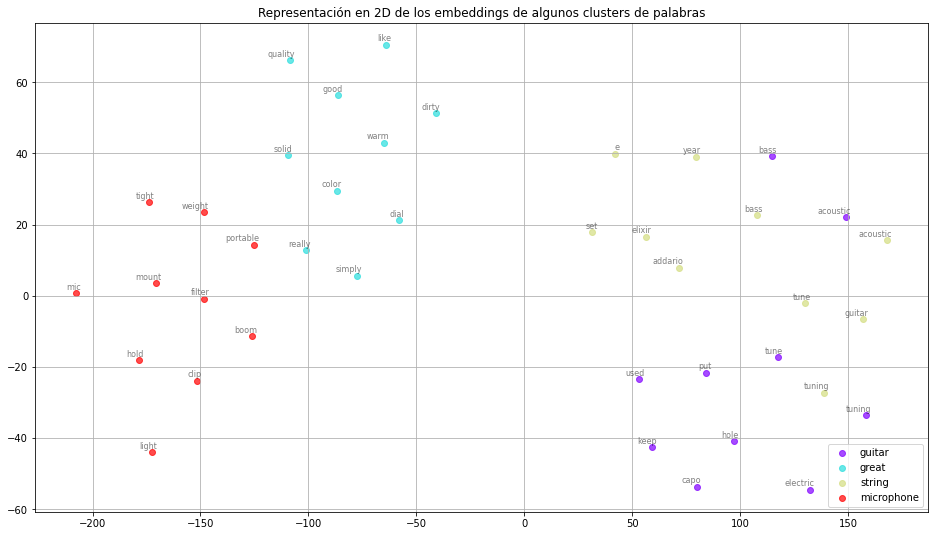

In [569]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

**Observaciones**

* Vemos que con CBOW los clusters no parecen tan cláremanete difenreciados como con Sikp Gram. Esto probablemnete se debe a que tenemos pocas muestras y Skip Gram tiene mejor comportamiento con pocas muestras, dado que predice el contexto de la palabra data. 
* Observamos que, aunque en diferentes direcciones, exite un cierto eje entre conjuntos de dos palabras: 
* *guitar* y *string* en el primer caso (sg) están muy cercanos y en el 
segundo caso (CBOW) están incluso entremezclados, esto puede deberse a que  ambos instrumentos son de cuerda y en el contexto (por ejemplo comprar cuerdas) pueden llegar a entremezclares;
* en el caso de *great* y *microphone* ocurre algo parecedido, en este caso puede deberse a que gran parte de las reseñas de este producto contegan valoraciones positivas


# 2. Preprocesamiento del texto

**NOTA** Las siguientes etapas de este proyecto se realizaran con el subset de 947 muestras

In [570]:
# volvemos a nuestro subset original
print('Tamaño del data_subset -->', data_subset.shape)
data_subset.head(5)

Tamaño del data_subset --> (957, 3)


,reviewText,overall,sentiment_label
0,I bought this to use with my keyboard. I wasn'...,2,0
1,This Fender cable is the perfect length for me...,4,1
2,The Fender 18 Feet California Clear Instrument...,5,1
3,Realtively inexpensive patch cable for electri...,5,1
4,I didn't expect this cable to be so thin. It's...,2,0


### Preprocesado de los datos

In [571]:
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords 

# lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# stemming 
from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**NOTA** STOPWORD hemos comprobado con la gráfica de nube de palabras y n-grams que para el análisis de sentiemiento eliminar ciertas stopword puede sesgar el sentido de las frases, por lo que vamos a definir nuestro propio conjunto de stopword. 

Para ello usaremos la librería **nlppreprocess**, después eliminaremos una selección de stopword como puedes ser: 'but', 'a', 'at', 'i', 'or', 'and', 'is', 'are', 'you', etc.

Eejemplo **nlppreprocess**

In [572]:
! pip install nlppreprocess
from nlppreprocess import NLP
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [573]:
nlp = NLP(
       replace_words=True,
       remove_stopwords=True,
       remove_numbers=True,
       )

print(("This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!"))
print(nlp.process("This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!"))

This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!
just test  But wasn t test  would make Great movie review 


In [574]:
# definimos función de preprocesado
def preprocess(review):

  # minúsculas
  review = review.lower()

  # indicamos stopwords
  stopwords = ['but', 'a', 'at', 'i', 'or', 'and', 'is', 'are', 'you', 'he', 'she', 'it', 'we', 'they', 'the', 'to', 'of', 'on', 'if', 'be', 'my', 'so', 'for', 'it', 'by', 'in', 't']

  # convertimos el texto en string
  sentence = str(review)

  # nlppreprocess
  text = nlp.process(sentence)

  # limpiamos texto: HTML, urls, simbols, numbres, etc.
  sentence = text.replace('{html}',"") 

  cleaner = re.compile('<.*?>')
  clean_text = re.sub(cleaner, '', sentence)

  rem_url = re.sub(r'http\S+', '',clean_text)
  rem_num = re.sub('[0-9]+', '', rem_url)
  rem_num = re.sub(r"[^a-zA-Z0-9]", " ", rem_num)

  # tokenizamos - dividimos por espacios
  words = rem_num.split()

  # eliminamos stopwords
  words = [w for w in words if w not in stopwords]
  # words = [w for w in words if w not in stopwords.words("english")]

  # aplicamos stemming
  words = [PorterStemmer().stem(w) for w in words]
  
  # prueba Lemmatizer
  #lemmatizer = WordNetLemmatizer()
  # words = [lemmatizer.lemmatize(w).strip() for w in words]
    
  return ' '.join(words)

In [575]:
print(preprocess("This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!"))

just test wasn test would make great movi review


In [576]:
# preprocesamos reviews
for x in range(data_subset.shape[0]):
  review =data_subset.loc[x]['reviewText']
  data_subset.loc[x, 'reviewText'] = preprocess(review)

In [577]:
data_subset.head(4)

,reviewText,overall,sentiment_label
0,bought use with keyboard wasn realli awar ther...,2,0
1,fender cabl perfect length me sometim find bit...,4,1
2,fender feet california clear instrument cabl l...,5,1
3,realtiv inexpens patch cabl electr guitar had ...,5,1


In [578]:
# confirmamos que no tenemos null

data_subset.isnull().sum()

reviewText         0
overall            0
sentiment_label    0
dtype: int64

### Disvisión trin-test

In [579]:
from sklearn.model_selection import train_test_split

In [580]:
# dividimos en train test
SEED = 20
X_train, X_test, y_train, y_test = train_test_split(data_subset['reviewText'], data_subset['sentiment_label'], train_size=0.80, test_size=0.20, random_state=SEED, shuffle=True)

In [581]:
# mostramos dimensiones
print(f'Dimensiones del dataset de X_train: {X_train.shape}')
print(f'Dimensiones del dataset de y_train: {y_train.shape}')
print(f'Dimensiones del dataset de X_test: {X_test.shape}')
print(f'Dimensiones del dataset de y_test: {y_test.shape}')

Dimensiones del dataset de X_train: (765,)
Dimensiones del dataset de y_train: (765,)
Dimensiones del dataset de X_test: (192,)
Dimensiones del dataset de y_test: (192,)


In [582]:
X_train

580    purchas these four no good arriv anoth fail af...
543    cover not fit full size acoust electr hohner g...
589    work well pretti straight forward littl over p...
439    string rust veri easili yield fairli poor tone...
718    it perfectli done seem it not fit squir fender...
                             ...                        
924    case perfect store guitar would not recommend ...
223    stay clear use pedal most play carrier over ye...
271    pretti disappoint color review titl indic what...
474    love make plug lot stomp box easi peasi quiet ...
355    crikey where begin firstli hate fact packag tw...
Name: reviewText, Length: 765, dtype: object

# 3. Entrenamiento y testeo. Modelos

## **MODELO 1** Classic Machine Learning

**TF-IDF + Random Forest Classifier**

Para este primer modelo usaremos la téctinca de TF-IDF para la extracón de features. Decidimos usar TF-IDF debido a que tiene en cuenta la frecuencia de una palabra en un documento, ponderada por la frecuencia con la que aparece en todo el corpus. 

Teniendo en cuenta nuestro preprocesamiento y el tipo de análisis a desarrollar, clasificación de reseñas, TF-IDF parece una técnica más adecuada que Count Vectorizer, que únicamente tiene en cuanta el número de ocurrencias de una palabra.

### TF-IDF

In [583]:
# establecemos valores
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(
            ngram_range=(1,4),
            max_df=1.0,
            min_df=3,
            max_features=3000)

In [584]:
X_train_transform = tf_idf_vectorizer.fit(X_train)

X_traint_tfidf = tf_idf_vectorizer.transform(X_train)
X_test_tfidf = tf_idf_vectorizer.transform(X_test)

### Random Forest Classifier

In [585]:
import sklearn.preprocessing as pr

# normalizamos los datos
features_train = pr.normalize(X_traint_tfidf, axis=1)
features_test = pr.normalize(X_test_tfidf, axis=1)

In [586]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# select best params

# grid search
maxDepth = range(1,10)
tuned_parameters = {'max_depth': maxDepth, 'n_estimators': [100, 200, 500, 1000]}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=0, max_features='sqrt'), 
                    param_grid=tuned_parameters, cv=5, verbose = 1) 

grid_rf.fit(features_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_rf.best_score_))
print("best parameters: {}".format(grid_rf.best_params_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
best mean cross-validation score: 0.767
best parameters: {'max_depth': 7, 'n_estimators': 1000}


In [ ]:
from sklearn.metrics import accuracy_score

maxDepthOptimo = grid_rf.best_params_['max_depth']
neOptimo = grid_rf.best_params_['n_estimators']

rf = RandomForestClassifier(max_depth=maxDepthOptimo, n_estimators = neOptimo).fit(features_train, y_train)

# mostramos métricas 
print("Acurray: ",rf.score(features_train, y_train))

## **MODELO 2** Classic Machine Learning

**TF-IDF + Gradient Boosting Classifier**

In [588]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# select best params
maxDepth = range(1,10)
tuned_parameters = {'max_depth': maxDepth, 'n_estimators': [100, 200, 500]}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=0, max_features='sqrt'), 
                    param_grid=tuned_parameters, cv=5, verbose = 1) 

grid_gb.fit(features_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid_gb.best_score_))
print("best parameters: {}".format(grid_gb.best_params_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best mean cross-validation score: 0.765
best parameters: {'max_depth': 8, 'n_estimators': 100}


In [589]:
from sklearn.metrics import accuracy_score

# probamos modelo con los valores óptimos

maxDepthOptimo = grid_gb.best_params_['max_depth']
neOptimo = grid_gb.best_params_['n_estimators']
gb = RandomForestClassifier(max_depth=maxDepthOptimo, n_estimators = neOptimo).fit(features_train, y_train)

# mostramos métricas 
print("Acurray: ",gb.score(features_train,y_train))

Acurray:  0.9333333333333333


## **MODELO 3** Deep Learning

**Word Embeddings + GRU**

Dado que estamos trabajando con un subset extrído de todo el dataset, para desarrollar un modelo de deep learning decidimos entrenar una **GRU**, por dos razones:
* los modelos GRU suelen tener un mejor rendiemiento con menor cantidad de datos, en compracación con las LSTM;
* los modelos GRU entrenan más rápido que los modelos LSTM;

### Word Embeddings

In [590]:
import gensim
import multiprocessing as mp
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [591]:
max_words = int(np.quantile([len(words.split()) for words in X_train], 0.95))
max_words

179

In [592]:
W2V_SIZE = 300
W2V_WINDOW = 7
# 32
W2V_EPOCH = 5
W2V_MIN_COUNT = 2
# KERAS
SEQUENCE_LENGTH = max_words

In [593]:
def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

In [594]:
def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df]
    w2v_model = gensim.models.word2vec.Word2Vec(
        size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)
    
    words = w2v_model.wv.vocab.keys()
    vocab_size = len(words)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

In [595]:
def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )

In [596]:
tokenizer, vocab = generate_tokenizer(X_train)

Total words: 4326


In [597]:
word2vec_model = generate_word2vec(X_train)

Vocab size: 2509


In [598]:
from keras.preprocessing import sequence

max_words = max_words

X_train_words = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_words)
X_test_words = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_words)

### GRU

In [599]:
embedding_layer = generate_embedding(word2vec_model, vocab, tokenizer)

In [600]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN

model_gru = Sequential()
model_gru.add(embedding_layer)
model_gru.add(GRUV2(100))
model_gru.add(Dense(1, activation='sigmoid'))

print(model_gru.summary())

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 179, 300)          1297800   
                                                                 
 gru_18 (GRU)                (None, 100)               120600    
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,418,501
Trainable params: 120,701
Non-trainable params: 1,297,800
_________________________________________________________________
None


In [613]:
model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [614]:
batch_size = 128
num_epochs = 1

#X_train_words_valid, y_valid = X_train_words[:batch_size], y_train[:batch_size]
#X_train_words2, y_train2 = X_train_words[batch_size:], y_train[batch_size:]

model_gru.fit(X_train_words, y_train,
          validation_data=(X_test_words, y_test),
          batch_size=batch_size, epochs=num_epochs)

6/6 [==============================] - 8s 683ms/step - loss: 0.6910 - accuracy: 0.5451 - val_loss: 0.6899 - val_accuracy: 0.5104


# 4. Métricas y conclusiones

### MODELO 1: **TF-IDF + Random Forest Classifiert**

In [603]:
test_predict = rf.predict(features_test)
train_predict = rf.predict(features_train)

In [604]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score test  :{}'.format(accuracy_score(y_test, test_predict)))
print('Accuracy score train :{}'.format(accuracy_score(y_train, train_predict)))

Confussion matrix:
[[63 25]
 [25 79]]

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        88
           1       0.76      0.76      0.76       104

    accuracy                           0.74       192
   macro avg       0.74      0.74      0.74       192
weighted avg       0.74      0.74      0.74       192

Accuracy score test  :0.7395833333333334
Accuracy score train :0.938562091503268


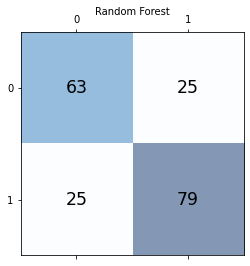

In [605]:
# Get the predictions
y_pred = rf.predict(features_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Random Forest', fontsize=10)
plt.show()

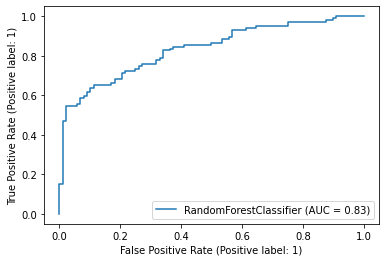

In [606]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf, features_test, y_test)
plt.show()

### MODELO 2: **TF-IDF + Gradient Boosting Classifier**

In [607]:
test_predict_gb = gb.predict(features_test)
train_predict_gb = gb.predict(features_train)

In [608]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict_gb)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict_gb)))
print('Accuracy score test  :{}'.format(accuracy_score(y_test, test_predict_gb)))
print('Accuracy score train :{}'.format(accuracy_score(y_train, train_predict_gb)))

Confussion matrix:
[[62 26]
 [25 79]]

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71        88
           1       0.75      0.76      0.76       104

    accuracy                           0.73       192
   macro avg       0.73      0.73      0.73       192
weighted avg       0.73      0.73      0.73       192

Accuracy score test  :0.734375
Accuracy score train :0.9333333333333333


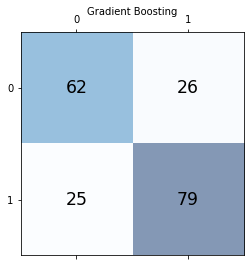

In [609]:
# Get the predictions
y_pred = gb.predict(features_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('Gradient Boosting', fontsize=10)
plt.show()

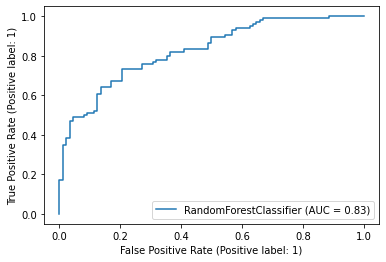

In [610]:
from sklearn.metrics import RocCurveDisplay
gb_disp = RocCurveDisplay.from_estimator(gb, features_test, y_test)
plt.show()

### MODELO 3: **Word Embeddings + GRU**

In [615]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model_gru.predict(X_test_words).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, Y_preds))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, Y_preds))

Test Accuracy : 0.4583333333333333

Classification Report : 
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        88
           1       0.00      0.00      0.00       104

    accuracy                           0.46       192
   macro avg       0.23      0.50      0.31       192
weighted avg       0.21      0.46      0.29       192


Confusion Matrix : 
[[ 88   0]
 [104   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


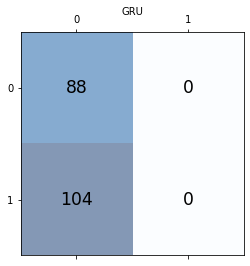

In [616]:
# Get the predictions
y_pred = model_gru.predict(X_test_words).argmax(axis=-1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.title('GRU', fontsize=10)
plt.show()

### **Observaciones**

**Random Forest VS Gradient Boosting**
* Vemos que los modelos de Machine Learning presentan un comprotamiento muy parecido, esto es ambos presentan **overfitting**;
* Observamos que **support** en ambos modelos presenta el mismo número, es decir el modelo presenta la misma tendencia, pues en ambos casos el accuracy es entrono al 0.75;
* Llama la atención que aunque ambos modelos presnetan mismo accuracy, en las métricas de **precision** y **recall** pareces tener tendencias claramente distintas. El modelo RF presenta valores más distantes entre positivos y negativos en **recall**, mientras que ocurre lo contrario en el modelo GB;
* Cabe señalar que los valores de **recall** diferenciados entre positivos y negativos en ambos modelos son bastante similares, por lo que podemos decir que estamos ante un dataset balanceado, como es el caso;
* Observamos que ambas curvas ROC son muy parecidas, pues algo esperable dado que el acurray en TEST es similar

**GRU**

* Vemos que el modelo GRU tiene un comprotamiento bastante caóptico con resultados muy malo, tal y como podeíamos esperar al haber obtenido una **acurracy** de al rededor del 0.50, es decir:
* El modelo no ha aparendido, sino más bien es una cuestión del azar clasificar una reseña como positiva o negativa;


### **Posibles mejoras**

**Random Forest VS Gradient Boosting**

* Cláramente debemos usar técnicas de regularización para poder eliminar overfitting:
* Ajustar valores de learning rate:
* Revisar el proceso de preprocesamiento de los datos: considerar aplicar otras técnicas de stopwords;


**GRU**

* Aunque el modelo de GRU debería funcionar con menos muestras, sin duda alguna, el número de muestras que tenemos para un modelo de deep learning es bastante reducida;
* Cláramente se debe revisar el preprocesamiento del corpus, y optrar por otro tipo de eliminación de stopword, dado que es altamente probable que el método aplicado genera excesiva carga de ruido;
* Probar com modelo LSTM;
